<a href="https://colab.research.google.com/github/Raphlawren/2D-Shape-prediction/blob/main/Vladmir_shape_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generating dummy data...
Dummy data for years 2010-2024 created in 'images/'.

--- Starting Training ---
Epoch [1/30], Loss: 0.728657
Epoch [5/30], Loss: 0.294675
Epoch [10/30], Loss: 0.330933
Epoch [15/30], Loss: 0.265952
Epoch [20/30], Loss: 0.171334
Epoch [25/30], Loss: 0.107618
Epoch [30/30], Loss: 0.081533
--- Training Finished ---

--- Generating Prediction ---

--- Evaluating Model Performance ---
ConvLSTM Model Metrics:
  - IoU: 0.9059
  - Dice: 0.9506
  - Hausdorff: 2.8071

--- Evaluating Naive Baseline (predicting last known shape) ---
Naive Baseline Metrics:
  - IoU: 0.8604
  - Dice: 0.9249
  - Hausdorff: 3.1623


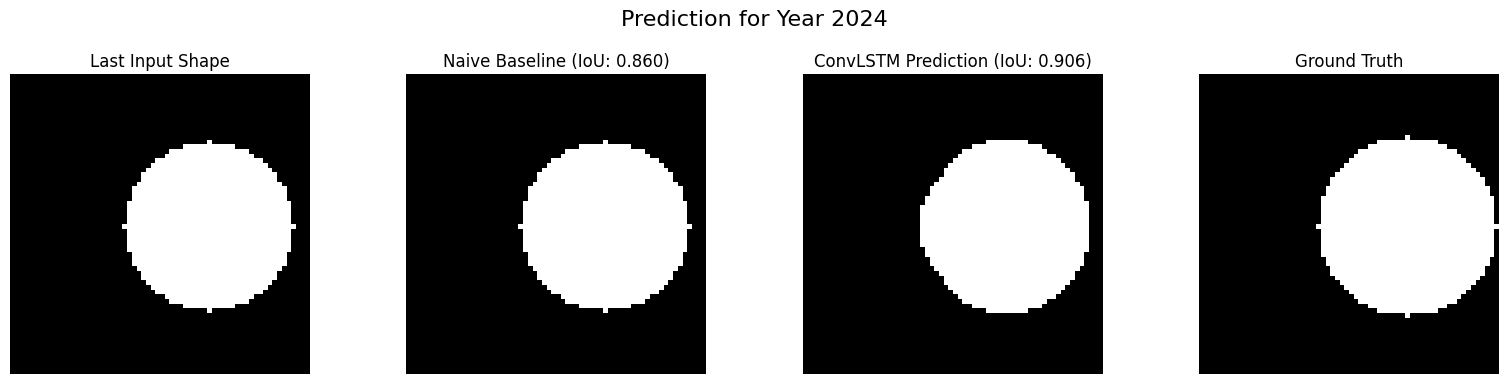

In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy.spatial.distance import directed_hausdorff
import random
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Configuration ---
CONFIG = {
    "image_dir": "images",
    "img_size": (64, 64),
    "sequence_length": 5, # Number of past years to use for prediction
    "epochs": 30,
    "batch_size": 4,
    "lr": 0.001,
    "hidden_dim": [64, 32], # Hidden dimensions for ConvLSTM layers
    "kernel_size": (3, 3),
    "monte_carlo_points": 20000,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# --- 2. Dummy Data Generation (for demonstration) ---
def create_dummy_data(image_dir, img_size, num_years=15):
    """Generates a sequence of images of a moving and expanding circle."""
    print("Generating dummy data...")
    os.makedirs(image_dir, exist_ok=True)
    H, W = img_size
    center_x, center_y = W // 4, H // 2
    radius = 5
    for i in range(num_years):
        year = 2010 + i
        img = np.zeros((H, W), dtype=np.uint8)

        # Move and expand the circle
        current_cx = center_x + i * 2
        current_cy = center_y
        current_r = radius + i

        Y, X = np.ogrid[:H, :W]
        dist_from_center = np.sqrt((X - current_cx)**2 + (Y - current_cy)**2)
        mask = dist_from_center <= current_r
        img[mask] = 255

        Image.fromarray(img).save(os.path.join(image_dir, f"{year}.png"))
    print(f"Dummy data for years 2010-{2010 + num_years - 1} created in '{image_dir}/'.")


# --- 3. Data Loading and Preprocessing ---
def load_and_preprocess_image(path, size):
    """Loads an image, converts to grayscale, resizes, and binarizes."""
    img = Image.open(path).convert('L').resize(size)
    img_np = np.array(img, dtype=np.float32)
    img_np = (img_np > 128).astype(np.float32) # Binarize: shape is 1, background is 0
    return img_np[np.newaxis, :, :] # Add channel dimension

class ShapeSequenceDataset(Dataset):
    def __init__(self, image_paths, seq_len):
        self.image_paths = sorted(image_paths)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.image_paths) - self.seq_len

    def __getitem__(self, idx):
        input_seq_paths = self.image_paths[idx : idx + self.seq_len]
        target_path = self.image_paths[idx + self.seq_len]

        input_seq = [load_and_preprocess_image(p, CONFIG["img_size"]) for p in input_seq_paths]
        target_img = load_and_preprocess_image(target_path, CONFIG["img_size"])

        # Stack to create a sequence tensor: (seq_len, channels, H, W)
        input_tensor = torch.from_numpy(np.stack(input_seq, axis=0))
        target_tensor = torch.from_numpy(target_img)

        return input_tensor, target_tensor


# --- 4. Model Definition (ConvLSTM) ---
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        padding = kernel_size[0] // 2, kernel_size[1] // 2

        self.conv = nn.Conv2d(in_channels=input_dim + hidden_dim,
                              out_channels=4 * hidden_dim,
                              kernel_size=kernel_size,
                              padding=padding,
                              bias=bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size):
        super(Seq2Seq, self).__init__()
        self.conv_lstm1 = ConvLSTMCell(input_dim, hidden_dim[0], kernel_size)
        self.conv_lstm2 = ConvLSTMCell(hidden_dim[0], hidden_dim[1], kernel_size)
        self.final_conv = nn.Conv2d(hidden_dim[1], input_dim, kernel_size=(1, 1))

    def forward(self, x):
        b, seq_len, _, h, w = x.size()
        h1, c1 = self.conv_lstm1.init_hidden(b, (h, w))
        h2, c2 = self.conv_lstm2.init_hidden(b, (h, w))

        # Encoding phase
        for t in range(seq_len):
            h1, c1 = self.conv_lstm1(x[:, t, :, :, :], (h1, c1))
            h2, c2 = self.conv_lstm2(h1, (h2, c2))

        # The last hidden state h2 is used for prediction
        prediction = self.final_conv(h2)
        return prediction


# --- 5. Training Loop ---
def train_model(model, dataloader, config):
    print("\n--- Starting Training ---")
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    criterion = nn.BCEWithLogitsLoss()
    model.to(config["device"])

    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(config["device"]), targets.to(config["device"])

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{config['epochs']}], Loss: {avg_loss:.6f}")
    print("--- Training Finished ---")


# --- 6. Evaluation Metrics ---
def get_boundary_points(mask, tolerance=0.8):
    """Extracts boundary points from a binary mask."""
    contours = find_contours(mask, tolerance)
    if not contours:
        return np.array([[0,0]]) # Handle empty case
    return np.concatenate(contours)

def monte_carlo_metrics(pred_mask, true_mask, num_points):
    """Calculates IoU and Dice using Monte Carlo simulation."""
    h, w = pred_mask.shape
    points_x = np.random.randint(0, w, num_points)
    points_y = np.random.randint(0, h, num_points)

    pred_values = pred_mask[points_y, points_x]
    true_values = true_mask[points_y, points_x]

    intersection = np.sum((pred_values == 1) & (true_values == 1))
    union = np.sum((pred_values == 1) | (true_values == 1))

    iou = intersection / union if union > 0 else 0.0
    dice = (2. * intersection) / (np.sum(pred_values) + np.sum(true_values)) if (np.sum(pred_values) + np.sum(true_values)) > 0 else 0.0
    return iou, dice

def hausdorff_distance(pred_mask, true_mask):
    """Calculates the directed Hausdorff distance."""
    pred_points = get_boundary_points(pred_mask)
    true_points = get_boundary_points(true_mask)

    dist1 = directed_hausdorff(pred_points, true_points)[0]
    dist2 = directed_hausdorff(true_points, pred_points)[0]

    return max(dist1, dist2)

def evaluate(pred_img, true_img, config):
    """Computes and returns a dictionary of evaluation metrics."""
    pred_mask = (pred_img > 0.5).astype(np.uint8)
    true_mask = (true_img > 0.5).astype(np.uint8)

    iou, dice = monte_carlo_metrics(pred_mask, true_mask, config["monte_carlo_points"])
    h_dist = hausdorff_distance(pred_mask, true_mask)

    return {"IoU": iou, "Dice": dice, "Hausdorff": h_dist}


# --- 7. Main Execution ---
if __name__ == "__main__":
    # Ensure dummy data exists for a runnable example
    if not os.path.exists(CONFIG["image_dir"]) or not os.listdir(CONFIG["image_dir"]):
        create_dummy_data(CONFIG["image_dir"], CONFIG["img_size"])

    # Load image paths and split into train/test
    all_files = sorted(glob.glob(os.path.join(CONFIG["image_dir"], "*.png")))
    if len(all_files) <= CONFIG["sequence_length"]:
        raise ValueError(f"Not enough images to form a single sequence. Need > {CONFIG['sequence_length']} images.")

    # Hold out the last sequence for testing
    train_files = all_files[:-1]
    test_input_files = all_files[-(CONFIG["sequence_length"] + 1) : -1]
    test_target_file = all_files[-1]

    # Create datasets and dataloaders
    train_dataset = ShapeSequenceDataset(train_files, CONFIG["sequence_length"])
    train_dataloader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)

    # Initialize and train the model
    model = Seq2Seq(input_dim=1, hidden_dim=CONFIG["hidden_dim"], kernel_size=CONFIG["kernel_size"])
    train_model(model, train_dataloader, CONFIG)

    # --- Prediction ---
    print("\n--- Generating Prediction ---")
    model.eval()
    with torch.no_grad():
        test_input_seq = [load_and_preprocess_image(p, CONFIG["img_size"]) for p in test_input_files]
        test_input_tensor = torch.from_numpy(np.stack(test_input_seq, axis=0)).unsqueeze(0) # Add batch dim
        test_input_tensor = test_input_tensor.to(CONFIG["device"])

        predicted_output = model(test_input_tensor)
        predicted_img = torch.sigmoid(predicted_output).cpu().numpy().squeeze()

    # Load ground truth for comparison
    ground_truth_img = load_and_preprocess_image(test_target_file, CONFIG["img_size"]).squeeze()

    # --- Evaluation ---
    print("\n--- Evaluating Model Performance ---")
    model_metrics = evaluate(predicted_img, ground_truth_img, CONFIG)
    print("ConvLSTM Model Metrics:")
    for key, val in model_metrics.items():
        print(f"  - {key}: {val:.4f}")

    # Evaluate the Naive Baseline
    print("\n--- Evaluating Naive Baseline (predicting last known shape) ---")
    naive_prediction_img = load_and_preprocess_image(test_input_files[-1], CONFIG["img_size"]).squeeze()
    baseline_metrics = evaluate(naive_prediction_img, ground_truth_img, CONFIG)
    print("Naive Baseline Metrics:")
    for key, val in baseline_metrics.items():
        print(f"  - {key}: {val:.4f}")

    # --- Visualization ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    fig.suptitle(f"Prediction for Year {os.path.basename(test_target_file).split('.')[0]}", fontsize=16)

    axes[0].imshow(load_and_preprocess_image(test_input_files[-1], CONFIG["img_size"]).squeeze(), cmap='gray')
    axes[0].set_title("Last Input Shape")

    axes[1].imshow(naive_prediction_img, cmap='gray')
    axes[1].set_title(f"Naive Baseline (IoU: {baseline_metrics['IoU']:.3f})")

    axes[2].imshow(predicted_img > 0.5, cmap='gray')
    axes[2].set_title(f"ConvLSTM Prediction (IoU: {model_metrics['IoU']:.3f})")

    axes[3].imshow(ground_truth_img, cmap='gray')
    axes[3].set_title("Ground Truth")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()